# Group 14 - Project FP01
## Time series anomaly detection - LSTM-ED

This project aims at investigating the current state-of-the-arts TAD scenario.

In [32]:
# !pip install pandas==1.5.3
# !pip install tsfel
# !pip install keras_tuner
# !pip install -U kaleido

In [33]:
import os
import time
import tsfel
import warnings
import datetime
import keras_tuner as kt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.cm as cm
from sklearn import metrics
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import preprocessing
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import auc

from dataset import get_df_action, get_features_ts, get_train_test_data
from plots import seaborn_cm, create_and_plot_cm, plot_uncertainty, plot_signals, plot_anomalies, plot_anomalies_over_time, plot_roc_curve
from metrics import Confidence, anomaly_detection_metric, compute_metrics

#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

# Set style for matplotlib
plt.style.use("Solarize_Light2")

In [34]:
# Path to the root directory of the dataset
ROOTDIR_DATASET_NORMAL =  '../dataset/normal'#'/content/drive/MyDrive/Kuka_v1/normal'
ROOTDIR_DATASET_ANOMALY = '../dataset/collisions'#'/content/drive/MyDrive/Kuka_v1/collisions'

# TF_ENABLE_ONEDNN_OPTS=0 means that the model will not use the oneDNN library for optimization

import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

### Dataset: Kuka-v1
In 5 different recording sessions, the robot executes several different operations, while being
monitored by several sensors. The sensed signals are collected, with different sampling frequencies
(1, 10, 100, 200 Hz),

### Data Loading

In [35]:
#freq = '1.0'
freq = '0.1'
#freq = '0.01'
#freq = '0.005'

# NORMAL DATA
filepath_csv = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_NORMAL, f"rec{r}_20220811_rbtc_{freq}s.metadata") for r in [0, 2, 3, 4]]
df_action, df, df_meta, action2int = get_df_action(filepath_csv, filepath_meta)


# COLLISION DATA
xls = pd.ExcelFile(os.path.join(ROOTDIR_DATASET_ANOMALY, "20220811_collisions_timestamp.xlsx"))
collision_rec1 = pd.read_excel(xls, 'rec1')
collision_rec5 = pd.read_excel(xls, 'rec5')

collisions = pd.concat([collision_rec1, collision_rec5])
collisions_init = collisions[collisions['Inizio/fine'] == "i"].Timestamp - pd.to_timedelta([2] * len(collisions[collisions['Inizio/fine'] == "i"].Timestamp), 'h')

collisions_adjusted = collisions.Timestamp - pd.to_timedelta([2] * len(collisions.Timestamp), 'h')
# transform in like collision
collisions['Timestamp'] = collisions_adjusted

filepath_csv = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.csv") for r in [1, 5]]
filepath_meta = [os.path.join(ROOTDIR_DATASET_ANOMALY, f"rec{r}_collision_20220811_rbtc_{freq}s.metadata") for r in [1, 5]]
df_action_collision, df_collision, df_meta_collision, action2int_collision = get_df_action(filepath_csv, filepath_meta)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



In [36]:
collisions_adjusted

0     2022-08-11 14:02:17.450
1     2022-08-11 14:02:21.460
2     2022-08-11 14:02:28.320
3     2022-08-11 14:02:31.420
4     2022-08-11 14:02:45.770
                ...          
107   2022-08-11 17:03:02.080
108   2022-08-11 17:03:44.090
109   2022-08-11 17:03:48.150
110   2022-08-11 17:04:10.600
111   2022-08-11 17:04:14.610
Length: 214, dtype: datetime64[ns]

In [37]:
collisions

,Inizio/fine,Timestamp
0,i,2022-08-11 14:02:17.450
1,f,2022-08-11 14:02:21.460
2,i,2022-08-11 14:02:28.320
3,f,2022-08-11 14:02:31.420
4,i,2022-08-11 14:02:45.770
...,...,...
107,f,2022-08-11 17:03:02.080
108,i,2022-08-11 17:03:44.090
109,f,2022-08-11 17:03:48.150
110,i,2022-08-11 17:04:10.600


### Features Exctraction

In [38]:
start_time = time.time()
frequency = 1/float(freq)
df_features = get_features_ts("statistical", df_action, df_meta, frequency, action2int)
df_features_collision = get_features_ts("statistical", df_action_collision, df_meta_collision, frequency, action2int_collision)
print("--- %s seconds ---" % (time.time() - start_time))

Computing features.


Skipped feature extraction for pickFromPallet(1,2)=[true,1,0] 2022-08-11 14:37:37.436000 : 2022-08-11 14:37:37.421000.
Skipped feature extraction for placeToPallet(1,1)=[true,0] 2022-08-11 14:37:37.421000 : 2022-08-11 14:37:37.442000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.568000 : 2022-08-11 15:36:32.533000.
Skipped feature extraction for pickFromPallet(3,2)=[true,1,0] 2022-08-11 15:36:32.572000 : 2022-08-11 15:36:32.561000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.533000 : 2022-08-11 15:36:32.572000.
Skipped feature extraction for placeToPallet(1,3)=[true,0] 2022-08-11 15:36:32.561000 : 2022-08-11 15:36:32.561000.
Computing features done.
Computing features.


Skipped feature extraction for moveOverPallet(1,3)=[true,0] 2022-08-11 16:55:15.149000 : 2022-08-11 16:55:15.146000.
Skipped feature extraction for moveOverPallet(3,1)=[true,0] 2022-08-11 16:55:15.146000 : 2022-08-11 16:55:15.150000.
Computing features done.
--- 123.51895117759705 seconds ---


In [39]:
def get_train_test_data(df_features, df_features_collision, full_normal=True):
    df_features.isnull().values.any()
    #df_features_nonan = df_features.drop((df_features.columns[df_features.isna().any()].tolist()), axis=1)
    df_features_nonan = df_features.fillna(0)
    df_features_collision_nonan = df_features_collision.fillna(0)

    # I normally want to train on the whole normal dataset
    if not full_normal:
        df_train, df_test = train_test_split(df_features_nonan)
    else:
        df_train = df_features_nonan
        df_test = df_features_collision_nonan
        
    X_train = df_train.drop(["label", "start", "end"], axis=1)
    y_train = df_train["label"]
    X_test = df_test.drop(["label", "start", "end"], axis=1)
    y_test = df_test["label"]

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train shape: {y_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    # Normalize features
    scaler = preprocessing.StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns, index=X_train.index)

    # Remove zero-variance features
    selector_variance = VarianceThreshold()
    selector_variance.fit(X_train)
    X_train = pd.DataFrame(selector_variance.transform(X_train),
                            columns=X_train.columns.values[selector_variance.get_support()])

    # Remove highly correlated features
    corr_features = tsfel.correlated_features(X_train,
                                            threshold=0.95)
    X_train.drop(corr_features, inplace=True, axis=1)

    # Lasso selector
    lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X_train, y_train)
    lasso = SelectFromModel(lsvc, prefit=True)
    selected_features = X_train.columns.values[lasso.get_support()]
    X_train = X_train[selected_features].copy()

    # Labels
    num_classes = len(set(y_train))
    y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)

    # Test
    X_test = pd.DataFrame(selector_variance.transform(scaler.transform(X_test)),
                        columns=X_test.columns.values[selector_variance.get_support()])
    X_test.drop(corr_features, inplace=True, axis=1)
    X_test = X_test[selected_features].copy()

    print(f"X_train shape: {X_train.shape}")
    print(f"y_train categorical shape: {y_train_categorical.shape}")
    print(f"y_train shape: {y_train.shape}")

    print(f"X_test shape: {X_test.shape}")
    print(f"y_test shape: {y_test.shape}")

    num_classes = len(y_train_categorical[0])
    
    return X_train, y_train, X_test, y_test, df_train, df_test


In [40]:
X_train, y_train, X_test, y_test, df_train, df_test = get_train_test_data(df_features, df_features_collision)

X_train shape: (973, 2200)
y_train shape: (973,)
X_test shape: (306, 2200)
y_test shape: (306,)
X_train shape: (973, 96)
y_train categorical shape: (973, 31)
y_train shape: (973,)
X_test shape: (306, 96)
y_test shape: (306,)


In [41]:
def label_collision_data(df_features, collisions_init):
# Create a binary label column initialized to 0 (no collision)
    df_features['is_collision'] = 0

    # Iterate over each collision interval
    for collision_time in collisions_init:
        mask = (df_features['start'] <= collision_time) & (df_features['end'] >= collision_time)
        
        df_features.loc[mask, 'is_collision'] = 1

    return df_features

In [42]:
df_with_labels = label_collision_data(df_features_collision, collisions_init)

In [43]:
df_with_labels.head(2)

,machine_nameKuka Robot_apparent_power-_Absolute energy,machine_nameKuka Robot_apparent_power-_Average power,machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_0,machine_nameKuka Robot_apparent_power-_ECDF Percentile Count_1,machine_nameKuka Robot_apparent_power-_ECDF Percentile_0,machine_nameKuka Robot_apparent_power-_ECDF Percentile_1,machine_nameKuka Robot_apparent_power-_ECDF_0,machine_nameKuka Robot_apparent_power-_ECDF_1,machine_nameKuka Robot_apparent_power-_ECDF_2,machine_nameKuka Robot_apparent_power-_ECDF_3,...,sensor_id5_GyroZ-_Min,sensor_id5_GyroZ-_Peak to peak distance,sensor_id5_GyroZ-_Root mean square,sensor_id5_GyroZ-_Skewness,sensor_id5_GyroZ-_Standard deviation,sensor_id5_GyroZ-_Variance,start,end,label,is_collision
0,2.731075e+06,275866.130066,20.0,80.0,164.857727,165.630737,0.01,0.02,0.03,0.04,...,0.0,0.0,0.0,NaN,0.0,0.0,2022-08-11 14:01:34.644,2022-08-11 14:01:44.644,0,0
1,2.723880e+06,275139.441030,20.0,80.0,164.642792,165.657715,0.01,0.02,0.03,0.04,...,0.0,0.0,0.0,NaN,0.0,0.0,2022-08-11 14:01:44.644,2022-08-11 14:01:54.644,0,0


In [44]:
y_test_collision = df_with_labels["is_collision"]


## LSTM-ED

In [45]:
from algorithms.lstm_enc_dec_axl import LSTMED

classifier = LSTMED(
    name='LSTM-ED',
    num_epochs=100,
    batch_size=32,
    lr=1e-4,
    hidden_size=64,
    sequence_length=100,
    train_gaussian_percentage=0.25,
    n_layers=(2, 2),
    use_bias=(True, True),
    dropout=(0.1, 0.1),
    seed=42,
    gpu=None,              # Set to None for CPU, or specify GPU index if available
    details=True
)
# Train the LSTM on normal data
classifier.fit(X_train)
print("LSTM-ED training completed.")


100%|██████████| 100/100 [05:41<00:00,  3.41s/it]


LSTM-ED training completed.


### Anomaly Detection

Anomaly prediction completed.


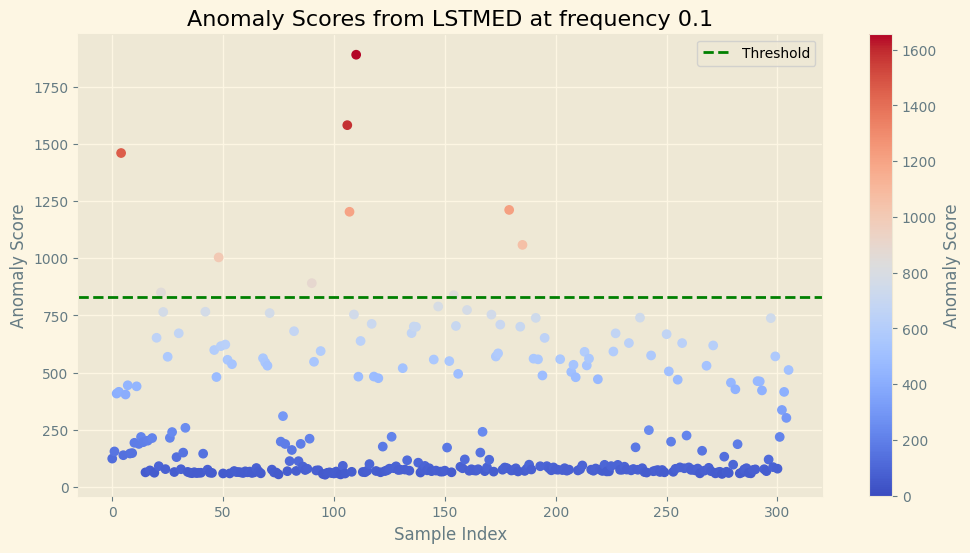

Number of anomalies detected: 10


In [46]:
anomaly_scores, anomalies_detected = plot_anomalies(classifier, X_test, y_test, freq)

In [57]:
from metrics import compute_metrics
anomaly_scores, y_test_binary= compute_metrics(classifier, X_test, y_test_collision)

Anomaly scores statistics:
Mean: 254.2063736846808
Std: 287.174224091753
Min: 53.90361031692124
Max: 1889.3730166300002
ROC AUC Score: 0.9862
Detected anomaly class: 1
Threshold: 828.5548
F1 Score: 0.1565
Accuracy: 0.6830
Precision: 0.9000
Recall: 0.0857
              precision    recall  f1-score   support

           0       0.68      1.00      0.80       201
           1       0.90      0.09      0.16       105

    accuracy                           0.68       306
   macro avg       0.79      0.54      0.48       306
weighted avg       0.75      0.68      0.58       306



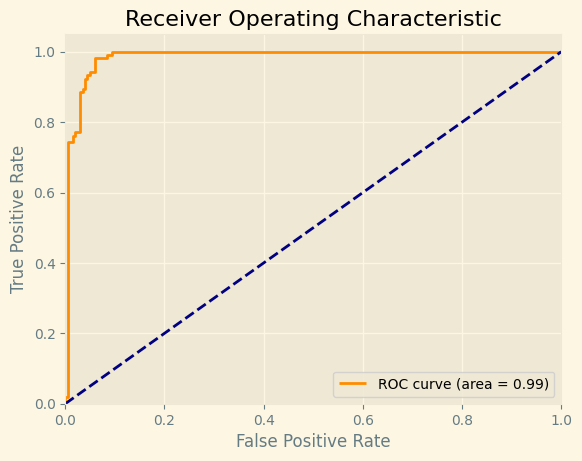

In [58]:
plot_roc_curve(y_test_collision.values, anomaly_scores)

## Map anomalies to original time series

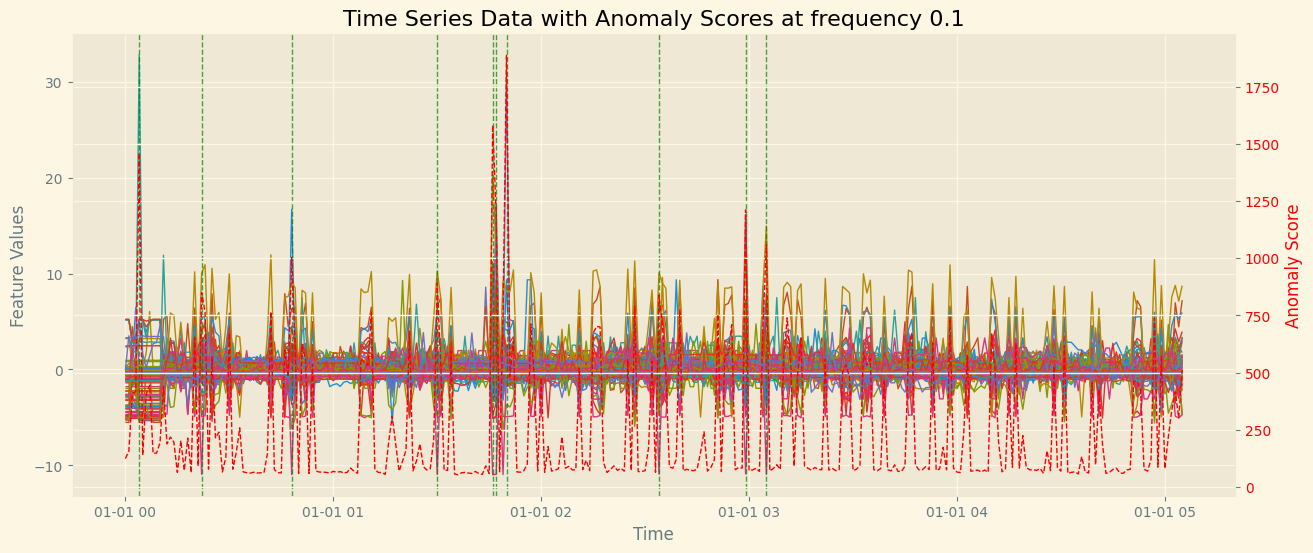

Top 10 Anomalies:
              timestamp  anomaly_score  \
110 2023-01-01 01:50:00    1889.373017   
106 2023-01-01 01:46:00    1581.560790   
4   2023-01-01 00:04:00    1459.771014   
179 2023-01-01 02:59:00    1211.168408   
107 2023-01-01 01:47:00    1203.039191   
185 2023-01-01 03:05:00    1058.365199   
48  2023-01-01 00:48:00    1003.621452   
90  2023-01-01 01:30:00     891.096935   
22  2023-01-01 00:22:00     850.469559   
154 2023-01-01 02:34:00     838.572862   

     machine_nameKuka Robot_apparent_power-_Average power  \
110                                          -0.911260      
106                                          -1.885449      
4                                            -5.323114      
179                                          -1.338344      
107                                          -1.181816      
185                                          -1.065886      
48                                           -0.707436      
90                             

In [60]:
plot_anomalies_over_time(X_test, anomaly_scores, anomalies_detected, freq)